In [1]:
# you have to delete the "generic_utils" from the file that makes the segmentatin_models import fail, then restart the runtime
!pip install tensorflow
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00


In [2]:
# import zipfile

# zip_file_path = '/content/ACDC.zip'
# extraction_path = '/content'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extraction_path)

In [51]:
import tensorflow as tf
import segmentation_models as sm
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

BACKBONE = 'resnet34'
BATCH_SIZE = 8
EPOCHS = 20
LR = 0.001
# n_classes = 4? - optional arg to model

preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 256
SIZE_Y = 256

train_images = []
for img_path in os.listdir(f'./ACDC/database/train'):
    img = cv2.imread(f'./ACDC/database/train/{img_path}', cv2.IMREAD_COLOR)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    train_images.append(img)
train_images = np.array(train_images)

train_masks = []
for mask_path in os.listdir(f'./ACDC/database/trainannot'):
    mask = cv2.imread(f'./ACDC/database/trainannot/{mask_path}', 0)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
    #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
    train_masks.append(mask)
train_masks = np.array(train_masks).astype(float)

X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3)



In [50]:
print(train_images)

[[[[  0.   0.   0.]
   [  2.   2.   2.]
   [  3.   3.   3.]
   ...
   [ 23.  23.  23.]
   [ 25.  25.  25.]
   [ 28.  28.  28.]]

  [[  0.   0.   0.]
   [  1.   1.   1.]
   [  3.   3.   3.]
   ...
   [ 44.  44.  44.]
   [ 46.  46.  46.]
   [ 48.  48.  48.]]

  [[  0.   0.   0.]
   [  1.   1.   1.]
   [  2.   2.   2.]
   ...
   [  9.   9.   9.]
   [ 10.  10.  10.]
   [ 11.  11.  11.]]

  ...

  [[ 10.  10.  10.]
   [ 83.  83.  83.]
   [115. 115. 115.]
   ...
   [ 38.  38.  38.]
   [ 35.  35.  35.]
   [ 34.  34.  34.]]

  [[ 10.  10.  10.]
   [ 76.  76.  76.]
   [ 98.  98.  98.]
   ...
   [ 37.  37.  37.]
   [ 35.  35.  35.]
   [ 34.  34.  34.]]

  [[  8.   8.   8.]
   [ 70.  70.  70.]
   [ 81.  81.  81.]
   ...
   [ 36.  36.  36.]
   [ 34.  34.  34.]
   [ 33.  33.  33.]]]


 [[[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  1.   1.   1.]
   [  3.   3.   3.]
   [  2.   2.   2.]]

  [[  1.   1.   1.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  7.   7.   7.]
 

In [11]:
import torch
torch.cuda.is_available()
device

True

In [27]:
# activation = 'sigmoid' # 'softmax' - ezzel kéne, csak fekete a kép
# optim = keras.optimizers.Adam(LR)

# # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# # total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

# metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [130]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
# x_train = preprocess_input(x_train)
# x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', activation='ReLU')
# model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
# model.compile(optimizer=optim, loss='binary_crossentropy', metrics=metrics) - ezzel valahogy működött, csak fekete a kép

# print(model.summary())

In [131]:
# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# # preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
# model = sm.Unet(BACKBONE, encoder_weights='imagenet')
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
# optim = keras.optimizers.Adam(LR)
model.compile(optimizer='Adam', loss=sm.losses.DiceLoss())

In [132]:
history=model.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 27s 218ms/step - loss: -5.5047 - val_loss: -77.4919
Epoch 2/20
16/16 [==============================] - 2s 157ms/step - loss: -16.3217 - val_loss: -48.2656
Epoch 3/20
16/16 [==============================] - 3s 158ms/step - loss: -26.3192 - val_loss: -24.7232
Epoch 4/20
16/16 [==============================] - 3s 162ms/step - loss: -37.8382 - val_loss: -126.8397
Epoch 5/20
16/16 [==============================] - 3s 159ms/step - loss: -48.8631 - val_loss: -178.7721
Epoch 6/20
16/16 [==============================] - 3s 169ms/step - loss: -59.3269 - val_loss: -137.3332
Epoch 7/20
16/16 [==============================] - 3s 169ms/step - loss: -65.7542 - val_loss: -139.6082
Epoch 8/20
16/16 [==============================] - 3s 171ms/step - loss: -75.1096 - val_loss: -21.0275
Epoch 9/20
16/16 [==============================] - 3s 162ms/step - loss: -81.7586 - val_loss: -58.9783
Epoch 10/20
16/16 [==============================] - 3s 161m

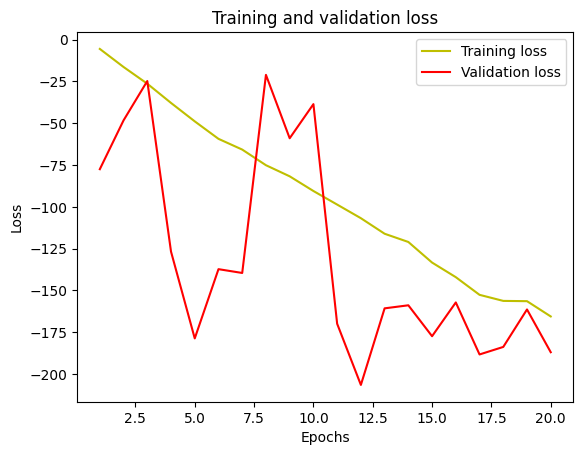

In [133]:
# accuracy = model.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.save('base_model_test.h5')

1/1 [==============================] - 0s 23ms/step


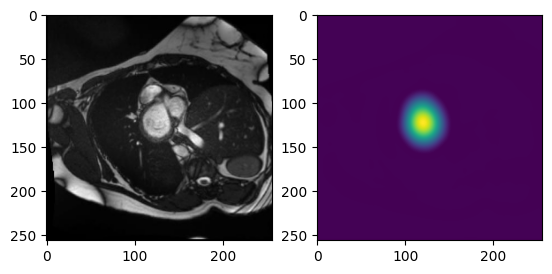

In [137]:

from tensorflow import keras
# model = keras.models.load_model('base_model_test.h5', compile=False)
#Test on a different image
test_img = cv2.imread('./ACDC/database/test/patient101_1.jpg', cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.subplot(1, 2, 1)
plt.imshow(test_img, cmap='gray')

test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.subplot(1, 2, 2)
plt.imshow(prediction_image)
plt.imsave('./test_segmented.jpg', prediction_image)



In [ ]:
# evaluate: test dataaset, model.load_weights('best_model.h5') ,
# print("Loss: {:.5}".format(scores[0]))
# for metric, value in zip(metrics, scores[1:]):
#     print("mean {}: {:.5}".format(metric.__name__, value))